***
# <span style='color:Blue'>Image classifier to detect plant and flower species </span>

***

In [1]:
import pandas as pd              # Perform operations on data frames
import numpy as np               # Perform numeric operations on data
import matplotlib.pyplot as plt  # For static visualizations
%matplotlib inline 
import seaborn as sns            # For advanced visualizations
import scipy.stats as stats      # To perform statistical operations
from scipy.stats import zscore
import warnings
import random
from zipfile import ZipFile
import os
import math
from numpy import array

#Loading all the necessary machine learning related modules
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE


#Import Tensorflow related packages
import tensorflow as tf
import keras_tuner as kt
import tflearn
import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, InputLayer,Conv2D,Convolution2D, Activation, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras import losses
from keras_tuner import RandomSearch
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
import random
from tensorflow.keras import backend
warnings.filterwarnings("ignore")


#Import CNN related packages
import cv2


Instructions for updating:
non-resource variables are not supported in the long term


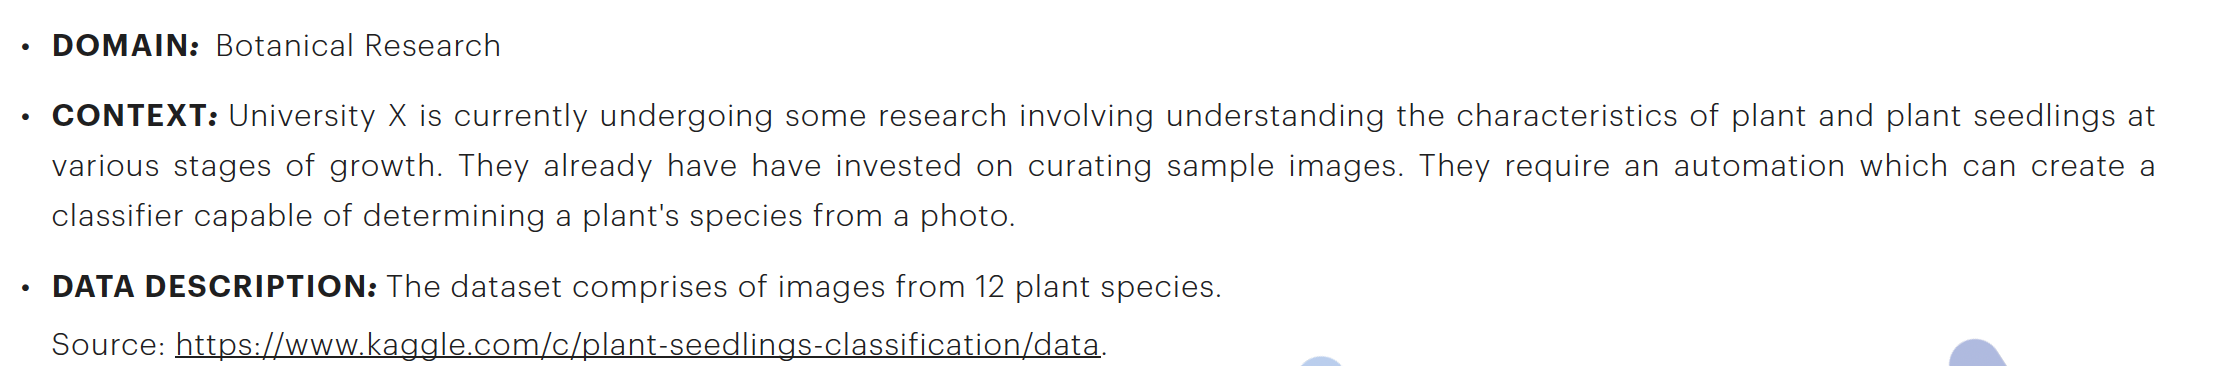

# Understand the data

#### Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped)

In [2]:
# Extracting all images into new folder named as 'plant-seedlings-images'
dirname = 'plant-seedlings-images'
with ZipFile('plant-seedlings-classification.zip','r') as myzip:
    myzip.extractall(dirname)

In [3]:
! ls plant-seedlings-images/

__MACOSX                       plant-seedlings-classification


#### Map the images from train folder with train labels to form a DataFrame

In [4]:
#Reading all the images from train folder and populating arrays with image names, labels and actual pixel values
dataset = 'plant-seedlings-images/plant-seedlings-classification/train'
image_name = []
labels = []
actual_image = []

# list all folders inside train directory
for i in os.listdir(dataset):
    if i!= '.DS_Store':
        print(i)
        for j in os.listdir(os.path.join(dataset,i)):
            #print(j)
            pix_matrix = cv2.imread(os.path.join(dataset, i, j))
            #print(pix_matrix.shape)
            actual_image.append(pix_matrix)
            image_name.append(j)
            labels.append(i)

Cleavers
Sugar beet
Common Chickweed
Loose Silky-bent
Scentless Mayweed
Shepherds Purse
Fat Hen
Common wheat
Black-grass
Small-flowered Cranesbill
Charlock
Maize


In [5]:
#Check the number of records
len(image_name), len(labels), len(actual_image)

(4750, 4750, 4750)

In [6]:
# Create a dataframe using populated arrays
df = pd.DataFrame({"name of Image": image_name,
                   "species" : labels,
                   "pixel array" : actual_image
                  })

In [7]:
df.head()

name of Image   species                                        pixel array
0  6a4ef17c2.png  Cleavers  [[[45, 61, 72], [50, 66, 73], [28, 47, 49], [2...
1  0515bc601.png  Cleavers  [[[146, 156, 161], [146, 156, 162], [147, 156,...
2  0ac327873.png  Cleavers  [[[67, 78, 91], [63, 73, 88], [63, 74, 88], [6...
3  94f82e916.png  Cleavers  [[[45, 62, 80], [42, 57, 78], [46, 60, 81], [4...
4  2c5c4d127.png  Cleavers  [[[62, 98, 137], [59, 96, 135], [62, 97, 136],...

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name of Image  4750 non-null   object
 1   species        4750 non-null   object
 2   pixel array    4750 non-null   object
dtypes: object(3)
memory usage: 111.5+ KB


**<span style='color:Blue'>Observations</span>**
- Data is read into a dataframe with file name, species(labels) and image pixel values

#### Write a function that will select n random images and display images along with its species

In [9]:
#Function to generate n random images with species labels
def getNRandomImages(val, height=20, width=20, retIndex=False): 
    rand = np.random.randint(0, len(df['pixel array']), val)
    print(rand)
    plt.figure(figsize=(height, width))
    for i,j in enumerate(rand):
        plt.subplot(1, len(rand), i+1)
        plt.imshow(df['pixel array'][j]) 
        plt.title("{}".format(df['species'][j]))
        plt.axis('off')
        #return  
    plt.show()

    # Return the Random Index values of the images as needed in Q3D 
    if retIndex == True:
        return rand

[2342   20 2974 2735  226]


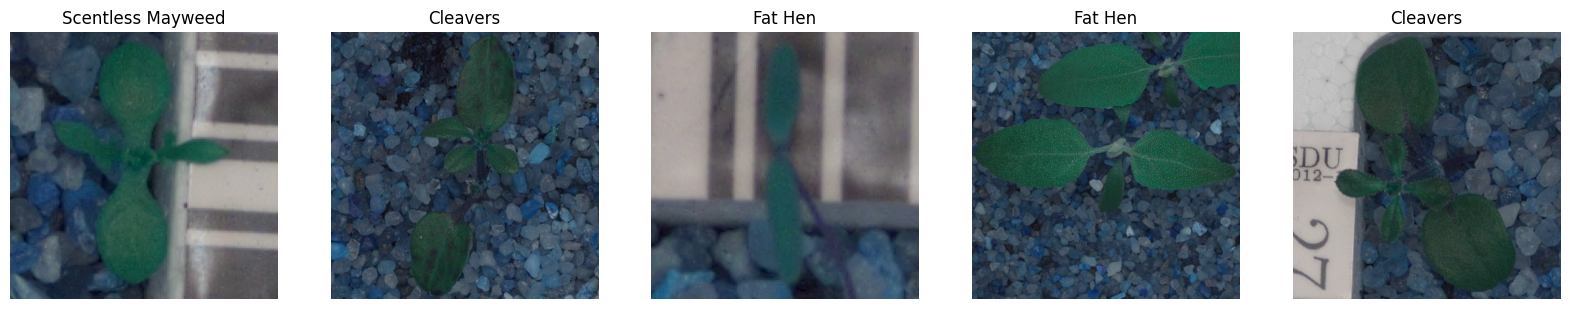

In [10]:
n = 5
getNRandomImages(n)

# Data preprocessing

#### Create X & Y from the DataFrame

In [11]:
#Create input features, X and class labels y from the appropriate columns in the above dataframe 
X = np.array(df['pixel array'])
y = np.array(df['species'])

In [12]:
#Check the dimensions of X and y
print(X.shape, y.shape)

(4750,) (4750,)


**<span style='color:Blue'>Note</span>**
- The pixel values in X will be appropriately reshaped in the subsequent questions for training purpose.

#### Encode labels of the images

In [13]:
#Encode the species labels into numeric classes 
label_encoder = preprocessing.LabelEncoder()

In [14]:
#Add a new column species_cat to store the numeric class in the dataframe 
df['species_cat'] = label_encoder.fit_transform(y)

In [15]:
df.head()

name of Image   species                                        pixel array  \
0  6a4ef17c2.png  Cleavers  [[[45, 61, 72], [50, 66, 73], [28, 47, 49], [2...   
1  0515bc601.png  Cleavers  [[[146, 156, 161], [146, 156, 162], [147, 156,...   
2  0ac327873.png  Cleavers  [[[67, 78, 91], [63, 73, 88], [63, 74, 88], [6...   
3  94f82e916.png  Cleavers  [[[45, 62, 80], [42, 57, 78], [46, 60, 81], [4...   
4  2c5c4d127.png  Cleavers  [[[62, 98, 137], [59, 96, 135], [62, 97, 136],...   

   species_cat  
0            2  
1            2  
2            2  
3            2  
4            2

In [16]:
#Map the species labels to its corresponding numeric classes
target_mapping = df[['species','species_cat']].drop_duplicates().sort_values(by='species_cat').reset_index(drop=True)
target_mapping

species  species_cat
0                 Black-grass            0
1                    Charlock            1
2                    Cleavers            2
3            Common Chickweed            3
4                Common wheat            4
5                     Fat Hen            5
6            Loose Silky-bent            6
7                       Maize            7
8           Scentless Mayweed            8
9             Shepherds Purse            9
10  Small-flowered Cranesbill           10
11                 Sugar beet           11

In [17]:
#Perform one-hot encoding of the numeric classes
y = to_categorical(df['species_cat'])

In [18]:
y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### Unify shape of all the images

In [19]:
#Converting shape of all images in X to 128*128 pixel size
imageSize = (128, 128)
X = [cv2.resize(img, imageSize) for img in X]

In [20]:
#Converting resized image data into numpy array
X = np.array(X)
X.shape

(4750, 128, 128, 3)

In [21]:
y.shape

(4750, 12)

#### Normalise all the images

In [22]:
#Check the initial minimum and maximum pixel values in X
np.amin(X), np.amax(X)

(0, 255)

In [23]:
#Normalise the image pixel values
maxColorVal = 255
X = X/maxColorVal

In [24]:
#Confirm the pixel values in X after normalization
np.amin(X), np.amax(X)

(0.0, 1.0)

## Model training

#### Split the data into train and test data

In [25]:
#Split the X and y into train and test data respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
#Print the shape of the train and test after splitting
print('Train_Shape:', X_train.shape, y_train.shape)
print('Test_Shape:', X_test.shape, y_test.shape)

Train_Shape: (3800, 128, 128, 3) (3800, 12)
Test_Shape: (950, 128, 128, 3) (950, 12)


#### Create new CNN architecture to train the model

In [27]:
# Clear backend session variables and intitialize random seed values
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

**CNN Model Architecture details**
- 4 Convolution layers + 2 MaxPooling
    - Input Image size 128 x 128 x 3
    - Filter size : 3*3
    - Activation function relu
-  Regularization Technique 
    - Batch Normalization
    - Dropout
- Fully Connected Layer
-  Output Layer
    - Softmax Activation
- Model compilation parameters
    - optimiser: Adam
    - learning rate: 0.001
    - loss function : Categorical crossentropy 

In [28]:
#Creation of CNN Model
model1 = Sequential()
model1.add(Conv2D(16, (3,3), padding='same', input_shape= (128,128,3), activation='relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.3))

model1.add(Flatten())
model1.add(Dense(12))
model1.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [29]:
# Add Callbacks to pick the best model parameters
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
adam_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model1.compile(adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                        

#### Train the model on train data and validate on test data

In [30]:
#Fit the model with Train data and validate using test data
model1_history =model1.fit(X_train, y_train, 
                           validation_data = (X_test, y_test), 
                           epochs = 15,callbacks=[earlystop])

Train on 3800 samples, validate on 950 samples
Metal device set to: Apple M1
Epoch 1/15


2023-03-26 10:11:44.153328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-26 10:11:44.153455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-26 10:11:44.168898: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-03-26 10:11:44.173865: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-26 10:11:44.174103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:11:44.210927: I tensorflow/core/grappler/optimizers/custom_graph

3800/3800 [==============================] - ETA: 0s - loss: 5.9632 - acc: 0.3700

2023-03-26 10:11:58.299185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3800/3800 [==============================] - 15s 4ms/sample - loss: 5.9632 - acc: 0.3700 - val_loss: 11.1631 - val_acc: 0.1347
Epoch 2/15
  32/3800 [..............................] - ETA: 15s - loss: 2.4493 - acc: 0.5938

2023-03-26 10:11:59.328423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3800/3800 [==============================] - 13s 3ms/sample - loss: 2.6852 - acc: 0.6637 - val_loss: 8.9822 - val_acc: 0.2158
Epoch 3/15
3800/3800 [==============================] - 13s 3ms/sample - loss: 1.6890 - acc: 0.7705 - val_loss: 9.3092 - val_acc: 0.2295
Epoch 4/15
3800/3800 [==============================] - 13s 3ms/sample - loss: 1.0260 - acc: 0.8300 - val_loss: 4.7049 - val_acc: 0.5095
Epoch 5/15
3800/3800 [==============================] - 13s 3ms/sample - loss: 0.7759 - acc: 0.8768 - val_loss: 3.2422 - val_acc: 0.6284
Epoch 6/15
3800/3800 [==============================] - 13s 3ms/sample - loss: 0.5543 - acc: 0.9021 - val_loss: 3.3751 - val_acc: 0.6568
Epoch 7/15
3800/3800 [==============================] - 13s 3ms/sample - loss: 0.3709 - acc: 0.9295 - val_loss: 3.8422 - val_acc: 0.5768
Epoch 8/15
3800/3800 [==============================] - 13s 3ms/sample - loss: 0.2349 - acc: 0.9489 - val_loss: 3.3357 - val_acc: 0.6968
Epoch 9/15
3800/3800 [==============================

In [31]:
#Prediction on the train data
model1_score_train = model1.evaluate(X_train, y_train, verbose=0)
print('Accuracy over the train set: \n ', round((model1_score_train[1]*100), 2), '%')

Accuracy over the train set: 
  98.21 %


In [32]:
#predict the accuracy value
model1_score_test = model1.evaluate(X_test, y_test, verbose=0)
print('Accuracy over the test set: \n ', round((model1_score_test[1]*100), 2), '%')

Accuracy over the test set: 
  73.89 %


In [33]:
model1_pred = model1.predict(X_test)

2023-03-26 10:15:03.711595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [34]:
model1_pred_final=[]
for i in model1_pred:
    model1_pred_final.append(np.argmax(i))
    
y_test_final=[]
for i in y_test:
    y_test_final.append(np.argmax(i))


In [35]:
#Performance metrics of the test dataset.
model1_cr = classification_report(y_test_final, model1_pred_final)
print(model1_cr)

              precision    recall  f1-score   support

           0       0.44      0.21      0.28        53
           1       0.65      0.95      0.77        78
           2       0.82      0.79      0.81        58
           3       0.91      0.75      0.82       122
           4       0.49      0.61      0.55        44
           5       0.87      0.64      0.74        95
           6       0.71      0.89      0.79       131
           7       0.77      0.84      0.80        44
           8       0.75      0.72      0.73       103
           9       0.53      0.41      0.46        46
          10       0.90      0.86      0.88        99
          11       0.69      0.79      0.73        77

    accuracy                           0.74       950
   macro avg       0.71      0.70      0.70       950
weighted avg       0.74      0.74      0.73       950



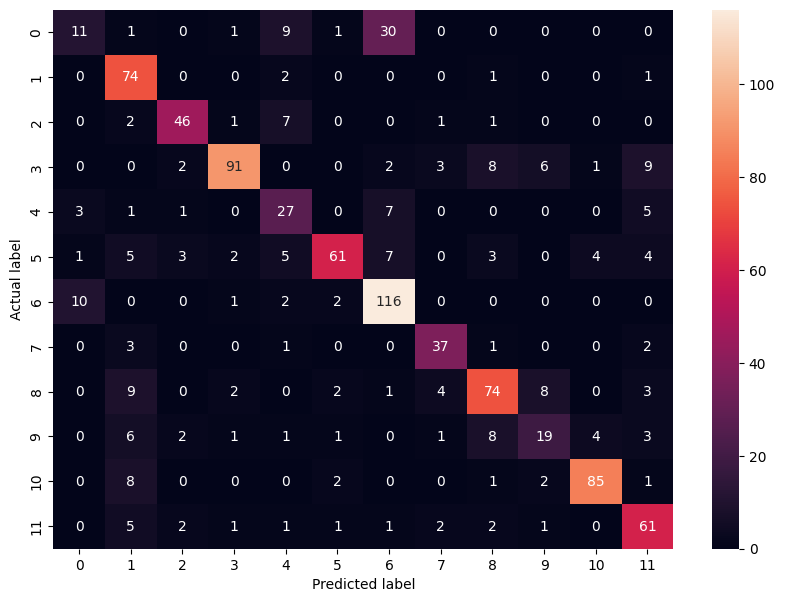

In [36]:
model1_cm=confusion_matrix(y_test_final, model1_pred_final)
plt.figure(figsize=(10,7))
sns.heatmap(model1_cm,annot=True,fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

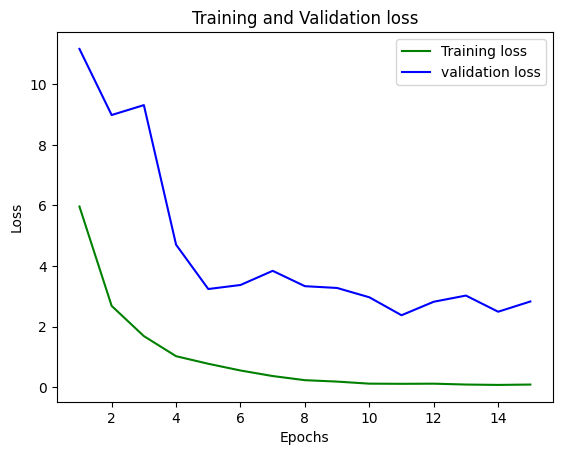

In [37]:
#Plotting Training vs Validation Loss
EPOCH=15
loss_train = model1_history.history['loss']
loss_val = model1_history.history['val_loss']
epochs = range(1,EPOCH+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

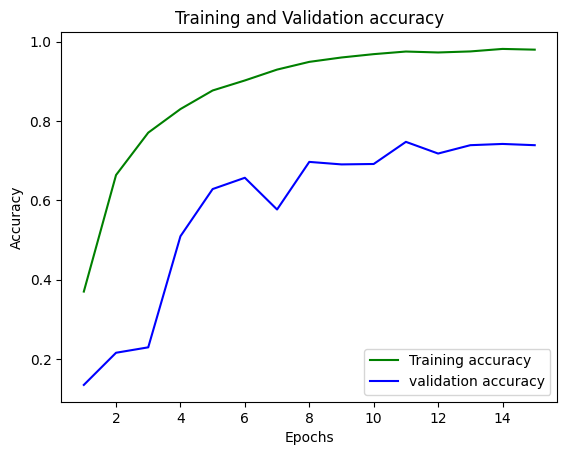

In [38]:
#Plotting Training vs Validation Accuracy
EPOCH=15
loss_train = model1_history.history['acc']
loss_val = model1_history.history['val_acc']
epochs = range(1,EPOCH+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**<span style='color:Blue'>Observation</span>**

- Based on the classification report, it can be seen that model achieved overall ~75% accuracy. 

- With `4 convolution layers` the model is a bit complex and is `overfitting` as the validation loss is higher than the training loss. Convergely, the training accuracy (98.21 %) is higher than the validation accuracy (73.89 %)

- There is scope for improving this model w.r.t the 
    - Overall architecture (Number of layers and nodes)
    - Optimisers, learning rate
    - Number of filters
    - Image Augmentation

#### Select a random image and print actual label and predicted label for the same

In [39]:
#Function to predict the species label of a random image

def image_prediction(image_ind, target_mapping):
    imageSize = (128, 128) # Define resize dimensions used for training
    for i in range(0, len(image_ind)):
        # Resize image
        image_resize= cv2.resize(df['pixel array'][image_ind[i]], imageSize)
        # Normalize image pixel values 
        image_norma = image_resize/255 
        # Prepare input array for model input
        img_query = image_norma.reshape(1, 128, 128, 3)
        # Predict the image class
        y_pred = model1.predict(img_query)
        # Get the numeric class from prediction
        y_pred_max = np.argmax(y_pred)
        # Map the numeric class with species label
        predicted_class = target_mapping.loc[target_mapping['species_cat'] == y_pred_max, 'species']
        return predicted_class.to_string()

[2225]


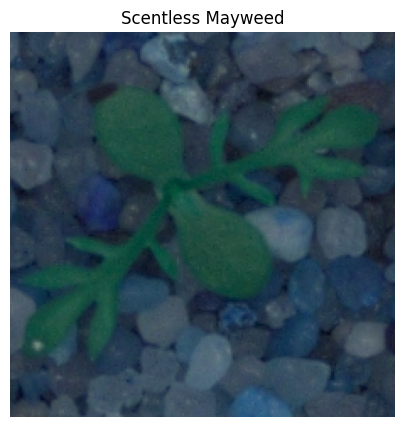

Actual label of the query target: Scentless Mayweed
Predicted labels of the query target 8    Scentless Mayweed


In [40]:
n = 1
# Generate random index to fetch image
index = getNRandomImages(n, height= 5, width=5, retIndex=True)

# Display image, actual label and predicted label
for label in index:
    print("Actual label of the query target:", df['species'][label])
predicted_class = image_prediction(index, target_mapping)
print("Predicted labels of the query target", predicted_class)

# Flower Classification

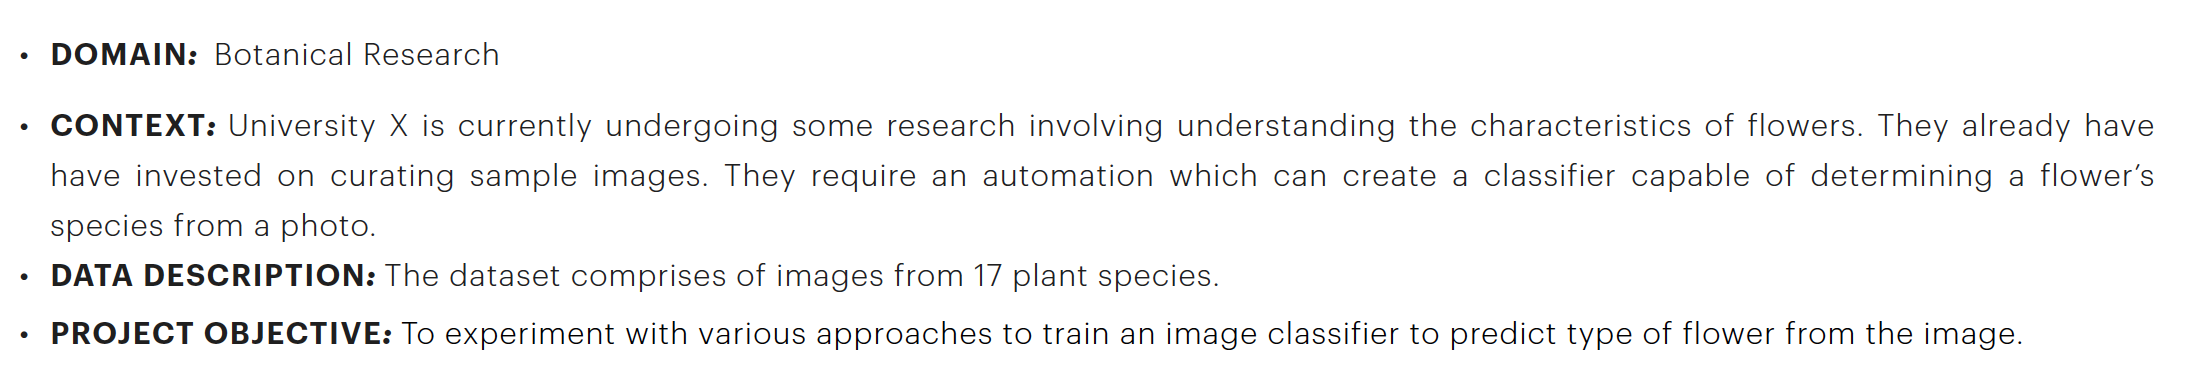

## Understand the flower data

#### Import and read oxflower17 dataset from tflearn and split into X and Y while loading

In [41]:
#Import the oxflower17 dataset and split into X and y
from tflearn.datasets import oxflower17
X, y = oxflower17.load_data()

#### Print Number of images and shape of the images

In [42]:
#Print the number of images in X
print("The number of images is", oxflower17.get_num_sample(X))

The number of images is 1360


In [43]:
print("The shape of the images", X.shape)

The shape of the images (1360, 224, 224, 3)


In [44]:
print("The number of labels in y", y.shape)

The number of labels in y (1360,)


#### Print count of each class from y

In [45]:
#Count of each class in y
y_class_count = pd.Series(y).value_counts().reset_index().rename(columns={"index" : "class", 0: "count"}).sort_values(by="class").reset_index(drop=True)
y_class_count

class  count
0       0     80
1       1     80
2       2     80
3       3     80
4       4     80
5       5     80
6       6     80
7       7     80
8       8     80
9       9     80
10     10     80
11     11     80
12     12     80
13     13     80
14     14     80
15     15     80
16     16     80

**<span style='color:Blue'>Observation</span>**
- There are a total of 17 classes (0 to 16) and each class has 80 images.

## Image Exploration & Transformation

#### Display 5 random images

[ 139 1105  431  945  530]


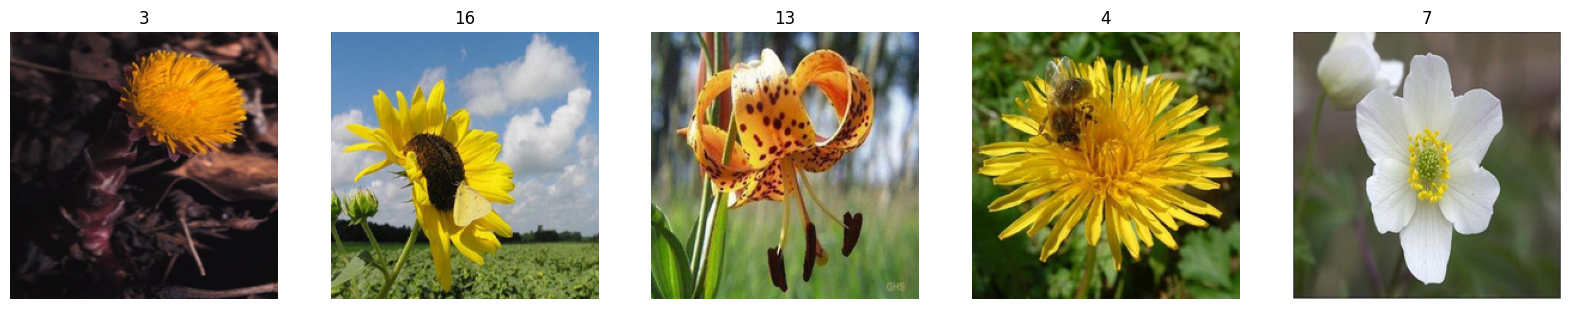

In [46]:
#Function to generate 5 random images
rand = np.random.randint(0, len(X), 5)
print(rand)
plt.figure(figsize=(20, 20))
for i,j in enumerate(rand):
    plt.subplot(1, len(rand), i+1)
    plt.imshow(X[j])  # greens, reds, blues, rgb
    plt.title("{}".format(y[j]))
    plt.axis('off')
plt.show()

#### Select any image from the dataset and assign it to a variable

In [47]:
#Randomly select an image from the dataset and assign it to a variable 
img_random = random.choice(X)

In [48]:
print("The shape of the randomly selected image is", img_random.shape)

The shape of the randomly selected image is (224, 224, 3)


####  Transform the image into grayscale format and display the same

In [49]:
#Tranform the randomly selected image from above and convert to a grayscale image
gray_image = cv2.cvtColor(img_random, cv2.COLOR_RGB2GRAY)

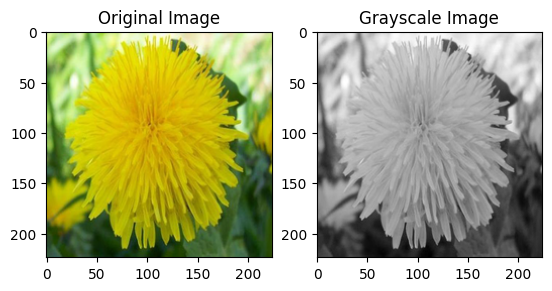

In [50]:
#Show the original image and the grayscale image
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_random)
axarr[1].imshow(gray_image, cmap='gray')
axarr[0].title.set_text('Original Image')
axarr[1].title.set_text('Grayscale Image')

#### Apply a filter to sharpen the image and display the image before and after sharpening

In [51]:
#Define a sharp filter
sharp_filter = np.array([[0,-1,0],
                        [-1,5,-1],
                        [0,-1,0]])

In [52]:
#Apply filter to the randomly selected image as above
sharp_img = cv2.filter2D(img_random,kernel=sharp_filter,ddepth=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


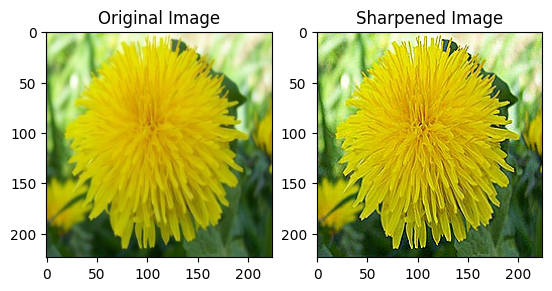

In [53]:
#Display image before and after sharpening
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_random)
axarr[1].imshow(sharp_img)
axarr[0].title.set_text('Original Image')
axarr[1].title.set_text('Sharpened Image')

#### Apply a filter to blur the image and display the image before and after blur

In [54]:
#Apply filter to blur the image
blur_img = cv2.GaussianBlur(img_random,ksize=(5,5),sigmaX=0,sigmaY=0)

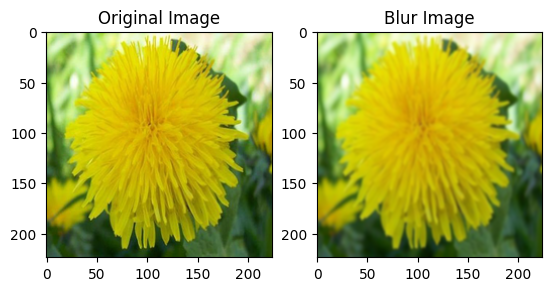

In [55]:
#Image before and after blur
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_random)
axarr[1].imshow(blur_img)
axarr[0].title.set_text('Original Image')
axarr[1].title.set_text('Blur Image')

#### Display all the 4 images from above questions besides each other to observe the difference

In [56]:
#Create a list of titles for the images
img_title = ['original_image', 'gray_image', 'sharp_image', 'blurred_image']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


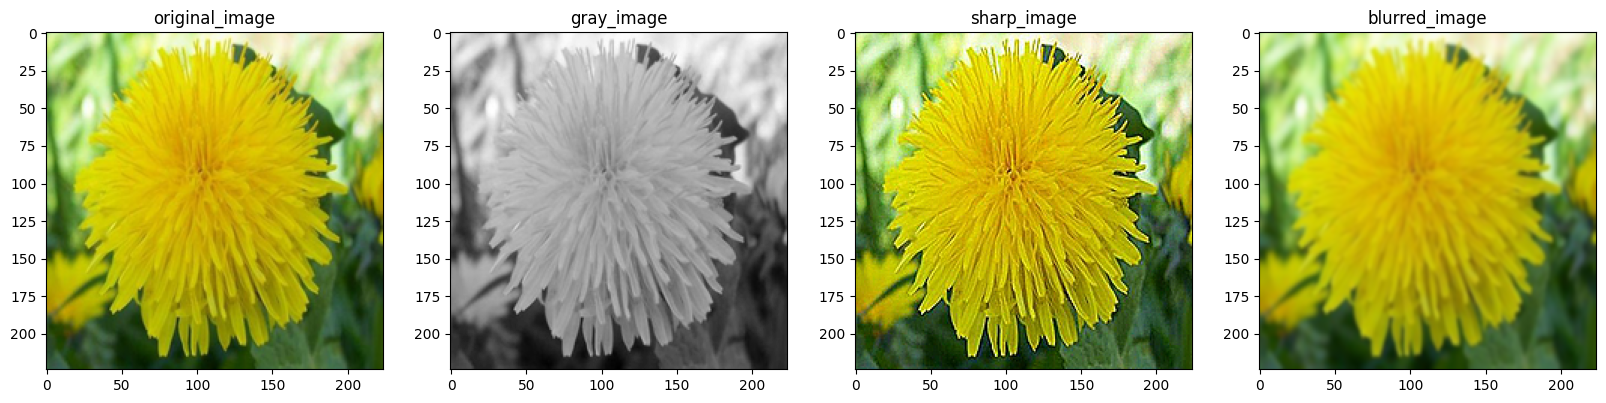

In [57]:
#Plot all the 4 images beside each other
plt.figure(figsize=(20,20))
for i,img in enumerate([img_random, gray_image, sharp_img, blur_img]):
    plt.subplot(1,4,i+1)
    plt.title(img_title[i])
    plt.imshow(img,cmap='gray')

## 3. Model training and Tuning

#### Split the data into train and test with 80:20 proportion

In [58]:
#Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [59]:
print('Train_Shape:', X_train.shape, y_train.shape)

Train_Shape: (1088, 224, 224, 3) (1088,)


In [60]:
print('Test_Shape:', X_test.shape, y_test.shape)

Test_Shape: (272, 224, 224, 3) (272,)


In [61]:
print("The minimum value of the X train data", np.amin(X_train))
print("The maximum value of the X train data", np.amax(X_train))

The minimum value of the X train data 0.0
The maximum value of the X train data 1.0


In [62]:
print("The minimum value of the test data", np.amin(X_test))
print("The maximum value of the test data", np.amax(X_test))

The minimum value of the test data 0.0
The maximum value of the test data 1.0


In [63]:
#Check the pixel values for one image as an example
X_train[0][:,:,0]

array([[0.64705884, 0.60784316, 0.6       , ..., 0.5568628 , 0.57254905,
        0.61960787],
       [0.627451  , 0.6156863 , 0.6039216 , ..., 0.5686275 , 0.56078434,
        0.5529412 ],
       [0.62352943, 0.627451  , 0.5921569 , ..., 0.56078434, 0.5686275 ,
        0.54901963],
       ...,
       [0.11764706, 0.11372549, 0.10196079, ..., 0.09019608, 0.09803922,
        0.10196079],
       [0.14509805, 0.1254902 , 0.11764706, ..., 0.08235294, 0.09411765,
        0.10196079],
       [0.16078432, 0.15294118, 0.13725491, ..., 0.07843138, 0.09019608,
        0.09803922]], dtype=float32)

**<span style='color:Blue'>Note</span>**
- The image pixel values are already normalised and are within the range of 0 to 1 as shown above.
- There won't be a need to further normalize it.

#### Train a model using any Supervised Learning algorithm and share performance metrics on test data

In [64]:
#Converting 3D array pixel values to a 1D array before creating a supervised learning model
X_train_ML = X_train.astype('float32')
X_train_ML = X_train_ML.reshape(X_train_ML.shape[0], 150528) # 224X224X3 = 150528

X_test_ML = X_test.astype('float32')
X_test_ML = X_test_ML.reshape(X_test_ML.shape[0], 150528)

print('Train_Shape:', X_train_ML.shape, y_train.shape)
print('Test_Shape:', X_test_ML.shape, y_test.shape)

Train_Shape: (1088, 150528) (1088,)
Test_Shape: (272, 150528) (272,)


In [65]:
# SVM selected as one of the supervised learning algorithm for image classification 
SVM = SVC()
SVM.fit(X_train_ML, y_train)

SVC()

In [66]:
SVM_Accuracy_train =SVM.score(X_train_ML, y_train)
print("Train Accuracy : ", SVM_Accuracy_train)

SVM_Accuracy_test =SVM.score(X_test_ML, y_test)
print("Test Accuracy : ", SVM_Accuracy_test)

Train Accuracy :  0.9154411764705882
Test Accuracy :  0.4889705882352941


In [67]:
#Predicting classes of the test dataset using SVM model
SVM_y_pred_test = SVM.predict(X_test_ML)

In [68]:
#Performance metrices on the test data
print(classification_report(y_test, SVM_y_pred_test))

              precision    recall  f1-score   support

           0       0.47      0.56      0.51        16
           1       0.26      0.38      0.31        16
           2       0.65      0.69      0.67        16
           3       0.33      0.25      0.29        16
           4       0.44      0.50      0.47        16
           5       0.30      0.44      0.36        16
           6       0.55      0.38      0.44        16
           7       0.63      0.75      0.69        16
           8       0.86      0.38      0.52        16
           9       0.26      0.38      0.31        16
          10       0.41      0.56      0.47        16
          11       0.36      0.31      0.33        16
          12       0.83      0.94      0.88        16
          13       0.62      0.50      0.55        16
          14       0.40      0.25      0.31        16
          15       0.45      0.31      0.37        16
          16       1.00      0.75      0.86        16

    accuracy              

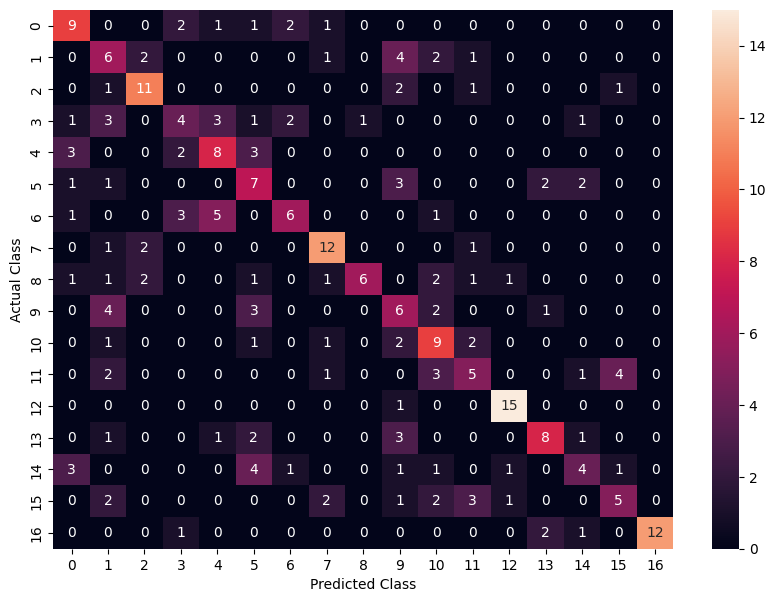

In [69]:
#Generate a heatmap based on the confusion matrix to show the Actual Vs Predicted labels
SVM_cm=confusion_matrix(y_test, SVM_y_pred_test)
plt.figure(figsize=(10,7))
sns.heatmap(SVM_cm,annot=True,fmt='d')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

**<span style='color:Blue'>Overall Observation of SVM Model</span>**
- Based on the classification report it is seen that all the most of the predicted classes have an `F1-score below 60%`, which means it has poor precision and recall values. 
- The model has a `training accuracy` of 91.5%  and `test accuracy` of ~49% . This tells us that the model is `extremely overfitting`, suggesting that it is `not a right choice` for image classification.

#### Train a model using Neural Network and share performance metrics on test data

In [70]:
# Changing the Target parameter as per the requirement of the NN model
# one-hot encode outputs
y_train_ohe = pd.get_dummies(y_train)
y_test_ohe = pd.get_dummies(y_test)

In [71]:
print("the shape of y_train after one-hot-encoding", y_train_ohe.shape)
print("the shape of y_test after one-hot-encoding", y_test_ohe.shape)

the shape of y_train after one-hot-encoding (1088, 17)
the shape of y_test after one-hot-encoding (272, 17)


In [72]:
# Clear backend session variables and intitialize random seed values
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

**Neural Network Architecture**
- There are 4 dense layers and 1 output layer
- Regularization Techniques
    - Batch Normalisation
    - Dropout
- Activation function 
    - Hidden layer: Relu
    - Output layer :Softmax 
- Model compilation parameters
    - Optimiser: Adam
    - Loss function : Categorical crossentropy

In [73]:
# create Neural Network model
model_NN = Sequential()  
model_NN.add(Dense(160,activation='relu', kernel_initializer='he_uniform',input_dim = X_train_ML.shape[1]))

model_NN.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_NN.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_NN.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))

model_NN.add(Dropout(rate=0.2))

model_NN.add(Dense(32, activation='relu'))
model_NN.add(Dense(17, activation='softmax'))

In [74]:
# Compile neural network model
optimizer = tf.keras.optimizers.Adam(1e-3)
model_NN.compile(loss = "categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [75]:
# Fit the model
NN_histroy = model_NN.fit(X_train_ML, y_train_ohe, validation_split = 0.20, epochs=50, batch_size=32, verbose=1)

Train on 870 samples, validate on 218 samples
Epoch 1/50


2023-03-26 10:20:56.441760: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-26 10:20:56.441785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-26 10:20:56.453284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:20:56.467751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:20:56.586626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:20:56.59

870/870 [==============================] - ETA: 0s - loss: 12.8485 - acc: 0.0701

2023-03-26 10:20:59.494138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


870/870 [==============================] - 3s 4ms/sample - loss: 12.8485 - acc: 0.0701 - val_loss: 2.8069 - val_acc: 0.0826
Epoch 2/50
870/870 [==============================] - 2s 3ms/sample - loss: 3.3385 - acc: 0.0782 - val_loss: 2.9140 - val_acc: 0.0413
Epoch 3/50
870/870 [==============================] - 2s 3ms/sample - loss: 3.1799 - acc: 0.0828 - val_loss: 2.7630 - val_acc: 0.0642
Epoch 4/50
870/870 [==============================] - 2s 3ms/sample - loss: 2.9885 - acc: 0.0897 - val_loss: 2.8369 - val_acc: 0.0550
Epoch 5/50
870/870 [==============================] - 2s 3ms/sample - loss: 2.8077 - acc: 0.1195 - val_loss: 2.7581 - val_acc: 0.0826
Epoch 6/50
870/870 [==============================] - 2s 3ms/sample - loss: 2.8005 - acc: 0.1149 - val_loss: 2.7618 - val_acc: 0.1147
Epoch 7/50
870/870 [==============================] - 2s 3ms/sample - loss: 2.8019 - acc: 0.1138 - val_loss: 2.7195 - val_acc: 0.1560
Epoch 8/50
870/870 [==============================] - 2s 3ms/sample - lo

In [76]:
#Prediction on the testdata
NN_y_test_pred = model_NN.predict(X_test_ML)

2023-03-26 10:22:51.713327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [77]:
#Converting prediction probabilities to class labels
NN_y_test_final=[]
for i in NN_y_test_pred:
    NN_y_test_final.append(np.argmax(i))

In [78]:
#Performance metrics of the test dataset.
NN_model_cr = classification_report(y_test, NN_y_test_final)
print(NN_model_cr)

              precision    recall  f1-score   support

           0       0.29      0.38      0.32        16
           1       0.33      0.19      0.24        16
           2       0.64      0.56      0.60        16
           3       0.33      0.31      0.32        16
           4       0.50      0.38      0.43        16
           5       0.27      0.38      0.32        16
           6       0.29      0.31      0.30        16
           7       0.56      0.62      0.59        16
           8       0.67      0.25      0.36        16
           9       0.25      0.25      0.25        16
          10       0.35      0.44      0.39        16
          11       0.38      0.56      0.45        16
          12       0.42      0.81      0.55        16
          13       0.67      0.38      0.48        16
          14       0.11      0.06      0.08        16
          15       0.57      0.50      0.53        16
          16       0.87      0.81      0.84        16

    accuracy              

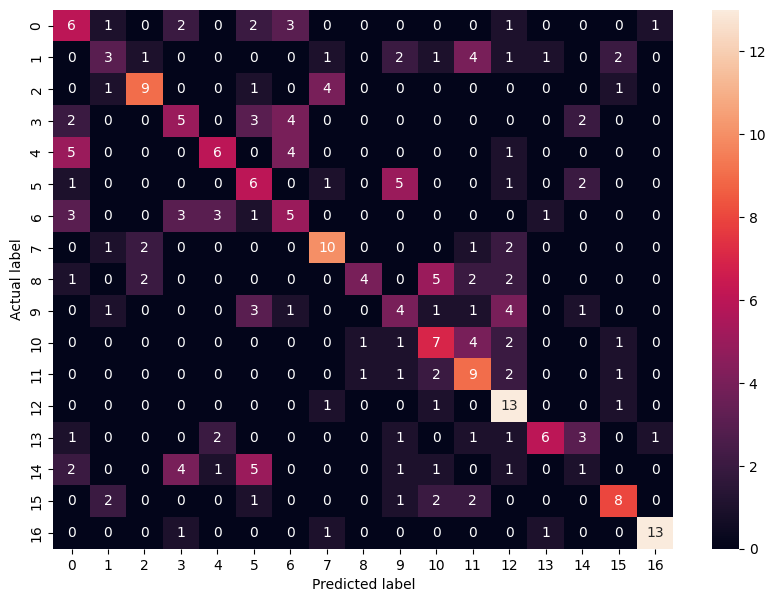

In [79]:
NN_cm=confusion_matrix(y_test, NN_y_test_final)
plt.figure(figsize=(10,7))
sns.heatmap(NN_cm,annot=True,fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

Text(0, 0.5, 'Loss')

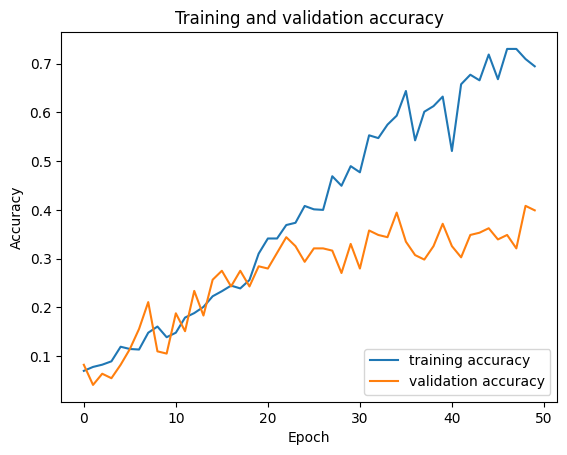

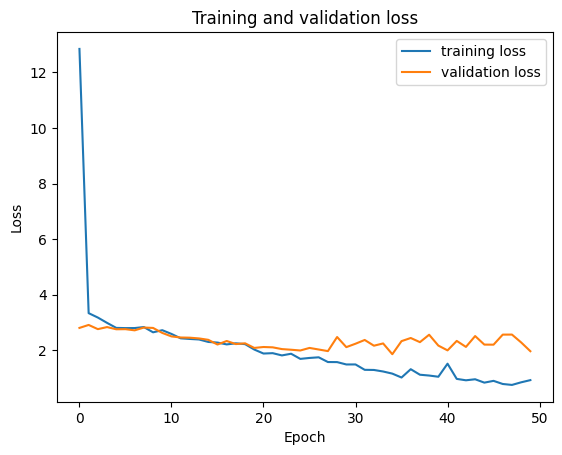

In [80]:
## Accuracy and Loss plots

accuracy = NN_histroy.history['acc']
val_accuracy = NN_histroy.history['val_acc']
loss = NN_histroy.history['loss']
val_loss = NN_histroy.history['val_loss']

epochs = range(len(accuracy)) # Get number of epochs

plt.plot(epochs, accuracy, label = 'training accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [81]:
# Accuracy of the model on train and test dataset
NN_Accuracy_train = model_NN.evaluate(X_train_ML, y_train_ohe)
print("Train Accuracy : ", NN_Accuracy_train[1])

NN_Accuracy_test=model_NN.evaluate(X_test_ML, y_test_ohe)
print("Test Accuracy : ", NN_Accuracy_test[1])

Train Accuracy :  0.7858456
Test Accuracy :  0.42279413


**<span style='color:Blue'>Overall Observation of Neural Network Model</span>**

- Based on the classification report, its observed that the `F1 score` for the all `predicted class` is very poor.
- Also from the above plots its seen that the  training accuracy is way higher than the test accuracy suggesting that the `model is overfitting`.
- This tells us that generating a neural network is `not a good choice` for image classification.

### Train a model using a basic CNN and share performance metrics on test data

#### Basic CNN Model

**CNN Model Architecture details**
- There are 4 convolution layers, 3 Dense layers and 1 output layer
    - Dimensionality reduction using MaxPooling2D
- Regularization Techniques
    - Dropout
- Activation function 
    - Hidden layer: Relu
    - Output layer :Softmax 
- Model compilation parameters
    - Optimiser: Adam
    - Loss function : Categorical crossentropy

In [82]:
# Clear backend session variables and intitialize random seed values
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [83]:
### Basic CNN Model
model1_CNN = Sequential()

model1_CNN.add(Convolution2D(filters = 16, kernel_size = 3, activation ='relu', input_shape = (224, 224, 3))) 
model1_CNN.add(MaxPooling2D(pool_size = 3))

model1_CNN.add(Convolution2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model1_CNN.add(MaxPooling2D(pool_size = 3))
model1_CNN.add(Dropout(0.3))

model1_CNN.add(Convolution2D(filters = 64, kernel_size = 3, activation ='relu', input_shape = (224, 224, 3))) 
model1_CNN.add(MaxPooling2D(pool_size = 3))

model1_CNN.add(Convolution2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model1_CNN.add(MaxPooling2D(pool_size = 3))
model1_CNN.add(Dropout(0.3))

model1_CNN.add(Flatten()) 

# fully connected layer
model1_CNN.add(Dense(units = 256,activation = 'relu'))
model1_CNN.add(Dense(units = 128, activation = 'relu'))

model1_CNN.add(Dense(units = 17, activation = 'softmax')) 

In [84]:
model1_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        1

In [85]:
optimizer = Adam(lr=0.001)
model1_CNN.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [86]:
model1_CNN_history = model1_CNN.fit(X_train, y_train_ohe, epochs = 50, validation_split= 0.2 , batch_size = 32)

Train on 870 samples, validate on 218 samples
Epoch 1/50


2023-03-26 10:22:55.014698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-26 10:22:55.014717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-26 10:22:55.025769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:22:55.041954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:22:55.109742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:22:55.12

870/870 [==============================] - ETA: 0s - loss: 2.8386 - acc: 0.0724

2023-03-26 10:22:58.287398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


870/870 [==============================] - 4s 4ms/sample - loss: 2.8386 - acc: 0.0724 - val_loss: 2.8282 - val_acc: 0.1193
Epoch 2/50
870/870 [==============================] - 2s 2ms/sample - loss: 2.7082 - acc: 0.1103 - val_loss: 2.6126 - val_acc: 0.1284
Epoch 3/50
870/870 [==============================] - 2s 2ms/sample - loss: 2.4041 - acc: 0.1506 - val_loss: 2.3030 - val_acc: 0.2248
Epoch 4/50
870/870 [==============================] - 2s 2ms/sample - loss: 2.1910 - acc: 0.2138 - val_loss: 2.0551 - val_acc: 0.2936
Epoch 5/50
870/870 [==============================] - 2s 2ms/sample - loss: 2.0457 - acc: 0.2851 - val_loss: 1.8678 - val_acc: 0.3716
Epoch 6/50
870/870 [==============================] - 2s 2ms/sample - loss: 1.7993 - acc: 0.3575 - val_loss: 1.7862 - val_acc: 0.3486
Epoch 7/50
870/870 [==============================] - 2s 2ms/sample - loss: 1.5707 - acc: 0.4414 - val_loss: 1.4912 - val_acc: 0.4587
Epoch 8/50
870/870 [==============================] - 2s 2ms/sample - los

In [87]:
#Prediction on the testdata
model1_CNN_y_test_pred = model1_CNN.predict(X_test)

2023-03-26 10:24:28.336927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [88]:
#Converting prediction probabilities to class labels
model1_CNN_y_test_final=[]
for i in model1_CNN_y_test_pred:
    model1_CNN_y_test_final.append(np.argmax(i))

In [89]:
#Performance metrics of the test dataset.
model1_CNN_cr = classification_report(y_test, model1_CNN_y_test_final)
print(model1_CNN_cr)

              precision    recall  f1-score   support

           0       0.50      0.56      0.53        16
           1       0.69      0.56      0.62        16
           2       0.93      0.88      0.90        16
           3       0.35      0.88      0.50        16
           4       0.75      0.75      0.75        16
           5       0.82      0.56      0.67        16
           6       0.71      0.31      0.43        16
           7       0.62      0.94      0.75        16
           8       0.90      0.56      0.69        16
           9       0.90      0.56      0.69        16
          10       0.88      0.88      0.88        16
          11       0.58      0.88      0.70        16
          12       0.84      1.00      0.91        16
          13       0.92      0.75      0.83        16
          14       0.29      0.12      0.17        16
          15       0.87      0.81      0.84        16
          16       0.93      0.81      0.87        16

    accuracy              

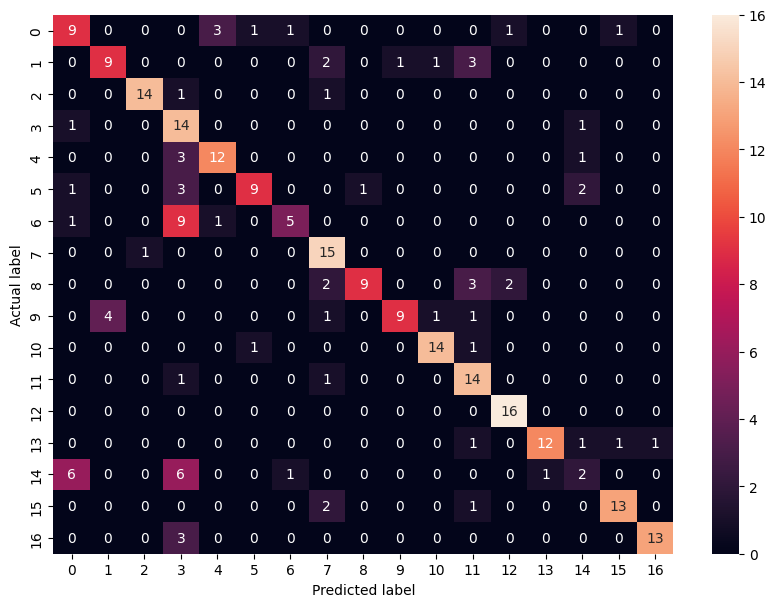

In [90]:
model1_CNN_cm=confusion_matrix(y_test, model1_CNN_y_test_final)
plt.figure(figsize=(10,7))
sns.heatmap(model1_CNN_cm,annot=True,fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

Text(0, 0.5, 'Loss')

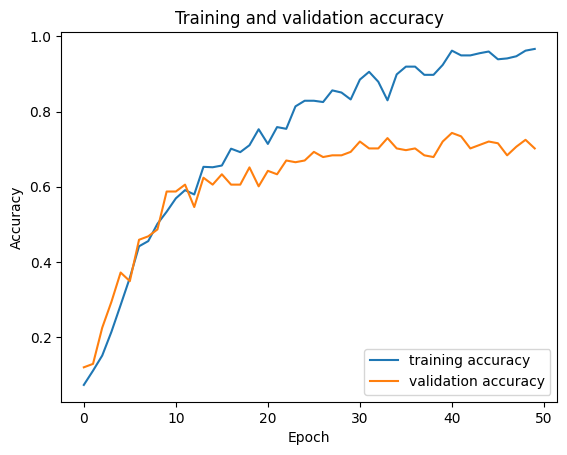

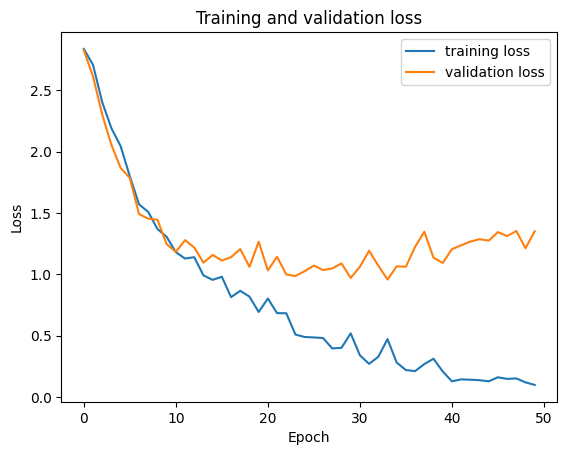

In [91]:
## CNN base model Accuracy and Loss plots

accuracy = model1_CNN_history.history['acc']
val_accuracy = model1_CNN_history.history['val_acc']
loss = model1_CNN_history.history['loss']
val_loss = model1_CNN_history.history['val_loss']

epochs = range(len(accuracy)) # Get number of epochs

plt.plot(epochs, accuracy, label = 'training accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [92]:
# Accuracy of the model on train and test dataset
CNN_Accuracy_train = model1_CNN.evaluate(X_train, y_train_ohe)
print("Train Accuracy : ", CNN_Accuracy_train[1])

CNN_Accuracy_test=model1_CNN.evaluate(X_test, y_test_ohe)
print("Test Accuracy : ", CNN_Accuracy_test[1])

Train Accuracy :  0.9117647
Test Accuracy :  0.69485295


**<span style='color:Blue'>Overall Observation of Basic CNN Model</span>**
- Based on the classification report, we can see that the there are few classes which has `F1-score less than 50`, suggesting `poor predictions` on those class/labels.
-  The above plot shows that the `training accuracy` is way `higher` than the `validation accuracy` suggesting that the model is `overfitting`.
- It is to be noted that the test accuracy for image classification on the `CNN basic model` is `higher` than the `supervised learning model` as well as the `neural network model` as described in previous questions. However, the base CNN model is also overfitting.
- Lets apply transfer learning algorithm and verify the model performance.

### CNN Model using VGGNet-16 without image augmentation

**CNN Model using VGGNet-16 Architecture without applying any image augmentation**
- VGG16 has 16-layer deep neural network
    - All layers expect the last 3 layers are to be re-trained
    - Dimensionality reduction: MaxPooling2D
- Regularization Techniques
    - Dropout
- 2 fully connected layer + 1 output layer
- Activation function 
    - Hidden layer: Relu
    - Output layer:Softmax 
- Model compilation parameters
    - Optimiser: Stochastic Gradient Descent +
                  momentum
    - Loss function : Categorical crossentropy

In [93]:
# Clear backend session variables and intitialize random seed values
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [94]:
#Load the VGG model
img_input = (224, 224, 3)
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=img_input)

# Freeze all the layers except for the last few layers: 
for layer in vgg_conv.layers[:-3]:
    layer.trainable = False
 
 
# Create the model
model_vgg = Sequential()
 
# Add the vgg convolutional base model
model_vgg.add(vgg_conv)
 
# Add new layers
model_vgg.add(Flatten())

# fully connected layer
model_vgg.add(Dense(units = 256,activation = 'relu'))
model_vgg.add(Dense(units = 128, activation = 'relu'))

# Output layer
model_vgg.add(Dense(17, activation='softmax'))
model_vgg.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 17)                2193      
                                                                 
Total params: 21,172,561
Trainable params: 11,177,489
Non-trainable params: 9,995,072
_________________________________________________________________


2023-03-26 10:24:30.710706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-26 10:24:30.710724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-26 10:24:30.715975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:24:30.724978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:24:30.828550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [95]:
# initialize the model and optimizer
sgd= optimizers.SGD(lr= 0.001,momentum=.9)
model_vgg.compile(loss="categorical_crossentropy", optimizer=sgd,
                  metrics=["accuracy"])

In [96]:
#Fit the model
import time
start_time = time.time()

vgg_history = model_vgg.fit(X_train, y_train_ohe, batch_size = 32, epochs= 15,
                            validation_split=0.2)

print("%s seconds" % (time.time() - start_time))

Train on 870 samples, validate on 218 samples
Epoch 1/15


2023-03-26 10:24:30.972206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:24:30.984029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:24:31.132999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:24:31.142138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


870/870 [==============================] - ETA: 0s - loss: 2.6590 - acc: 0.1874

2023-03-26 10:24:49.310686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


870/870 [==============================] - 23s 26ms/sample - loss: 2.6590 - acc: 0.1874 - val_loss: 2.1168 - val_acc: 0.3073
Epoch 2/15
870/870 [==============================] - 23s 27ms/sample - loss: 1.5262 - acc: 0.5402 - val_loss: 1.2660 - val_acc: 0.6055
Epoch 3/15
870/870 [==============================] - 24s 27ms/sample - loss: 0.6686 - acc: 0.8230 - val_loss: 0.8141 - val_acc: 0.7385
Epoch 4/15
870/870 [==============================] - 24s 28ms/sample - loss: 0.2598 - acc: 0.9448 - val_loss: 0.7255 - val_acc: 0.7569
Epoch 5/15
870/870 [==============================] - 24s 27ms/sample - loss: 0.1240 - acc: 0.9782 - val_loss: 0.6855 - val_acc: 0.7890
Epoch 6/15
870/870 [==============================] - 24s 28ms/sample - loss: 0.0528 - acc: 0.9977 - val_loss: 0.6010 - val_acc: 0.8165
Epoch 7/15
870/870 [==============================] - 25s 29ms/sample - loss: 0.0282 - acc: 1.0000 - val_loss: 0.6475 - val_acc: 0.8073
Epoch 8/15
870/870 [==============================] - 24s 2

In [97]:
#Prediction on the testdata
model_vgg_y_test_pred = model_vgg.predict(X_test)

2023-03-26 10:30:40.058823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [98]:
#Converting prediction probabilities to class labels
model_vgg_y_test_pred_final=[]
for i in model_vgg_y_test_pred:
    model_vgg_y_test_pred_final.append(np.argmax(i))

In [99]:
#Performance metrics of the test dataset.
model_vgg_cr = classification_report(y_test, model_vgg_y_test_pred_final)
print(model_vgg_cr)

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.93      0.81      0.87        16
           2       1.00      0.88      0.93        16
           3       0.93      0.88      0.90        16
           4       0.88      0.88      0.88        16
           5       0.63      0.75      0.69        16
           6       0.94      1.00      0.97        16
           7       0.88      0.94      0.91        16
           8       0.94      0.94      0.94        16
           9       0.67      0.88      0.76        16
          10       0.88      0.94      0.91        16
          11       0.80      0.75      0.77        16
          12       1.00      1.00      1.00        16
          13       0.92      0.69      0.79        16
          14       0.60      0.56      0.58        16
          15       0.93      0.81      0.87        16
          16       0.94      0.94      0.94        16

    accuracy              

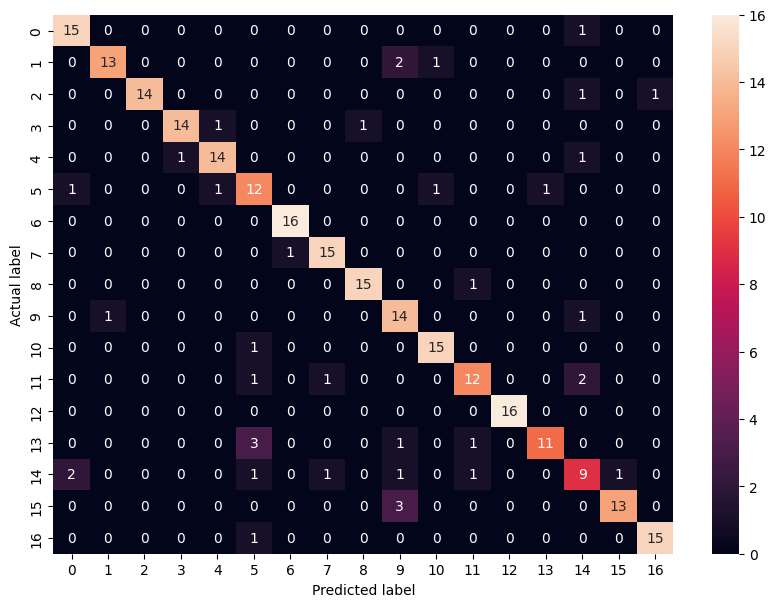

In [100]:
model_vgg_cm=confusion_matrix(y_test, model_vgg_y_test_pred_final)
plt.figure(figsize=(10,7))
sns.heatmap(model_vgg_cm,annot=True,fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

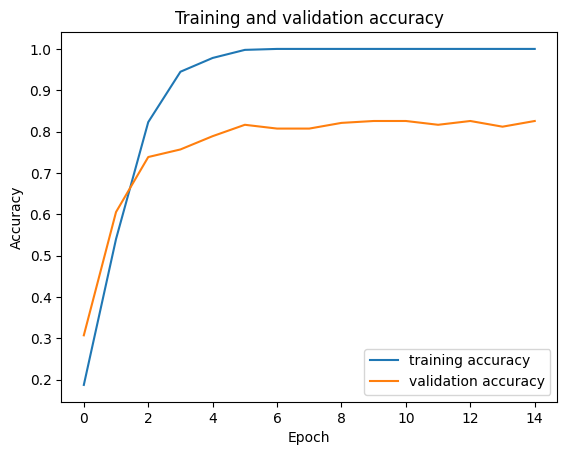

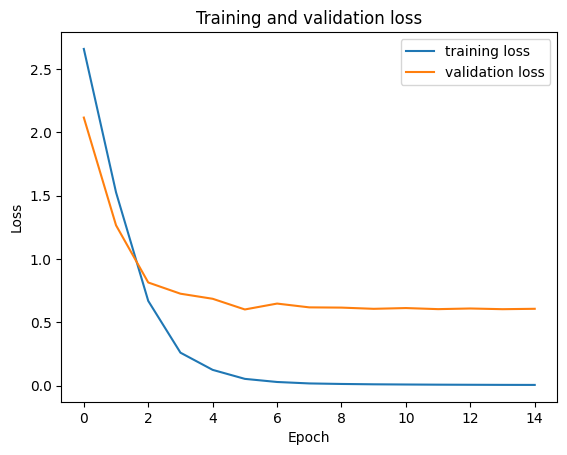

In [101]:
## CNN base model Accuracy and Loss plots

accuracy = vgg_history.history['acc']
val_accuracy = vgg_history.history['val_acc']
loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

epochs = range(len(accuracy)) # Get number of epochs

plt.plot(epochs, accuracy, label = 'training accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

In [102]:
# Accuracy of the model on train and test dataset
vgg_Accuracy_train = model_vgg.evaluate(X_train, y_train_ohe)
print("Train Accuracy : ", vgg_Accuracy_train[1])

vgg_Accuracy_test= model_vgg.evaluate(X_test, y_test_ohe)
print("Test Accuracy : ", vgg_Accuracy_test[1])

Train Accuracy :  0.9650735
Test Accuracy :  0.8566176


**<span style='color:Blue'> Observation of CNN Model using VGGNet-16 </span>**
- Based on the classification report, it is observed that most of the predicted class has an `F1-score greater than 75%`, suggesting a `good quality` classifier.
- From the above plots, it is seen that though the training and the validation, accuracy and the loss curves `forming an asymptote` and `not diverging` from each other completely.
- Overall, the test accuracy for image classification on the VGGNet-16 CNN model shows `higher accuracy` as compared to the `Basic CNN model`.

### CNN Model using VGGNet-16 with image augmentation

**CNN Model using VGGNet16 Architecture applying image augmentation**
- VGG16 has 16-layer deep neural network
    - All layers expect the last 4 layers considered to be re-trained
    - Dimensionality reduction using MaxPooling2D
- Regularization Techniques
    - Dropout

- 3 fully connected layer + 1 output layer

- Activation function 
    - Hidden layer: Relu
    - Output layer :Softmax 

- Apply Image augmentation technique to the train and the validation/test dataset 

- Model compilation parameters
    - Optimiser: RMSProp
    - Loss function : Categorical crossentropy

In [103]:
# Clear backend session variables and intitialize random seed values
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [104]:
# dividing images into train and test folders by creating images from arrays

def create_images(data, labels, folder):
    dirname=folder
    
    if not os.path.exists(dirname): #check if the folder exists; if not make dir
        os.mkdir(dirname)
    n=0
    
    for i in data:
        label_n=labels[n]
        subfolder = folder + "/" + str(label_n) 
        if not os.path.exists(subfolder): # create subfolders with categories
            os.mkdir(subfolder)  
        filepath =  subfolder + "/" + str(n)+ ".jpg"
        #print(n)
        #img = cv.convertScaleAbs(img, alpha=(255.0)
        cv2.imwrite(filepath, cv2.convertScaleAbs(data[n], alpha=(255.0))) #save image to corresponding subfolders
        n+=1

In [105]:
create_images(X_train, y_train, 'train')

In [106]:
create_images(X_test, y_test, 'test')

In [107]:
train_dir =os.path.realpath('train')
validation_dir = os.path.realpath('test')

In [108]:
#Load the VGG model
vgg_conv2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze aa few of the last layers: 
for layer in vgg_conv2.layers[:-4]:
    layer.trainable = False

    
# Create the model
model2_vgg = Sequential()
 
# Add the vgg convolutional base model
model2_vgg.add(vgg_conv2)
 
# Add new layers
model2_vgg.add(layers.Flatten())
model2_vgg.add(Dense(units = 256,activation = 'relu'))
model2_vgg.add(Dense(units = 128, activation = 'relu'))
model2_vgg.add(Dense(units = 64, activation = 'relu'))
model2_vgg.add(Dense(units = 17, activation = 'softmax'))
model2_vgg.summary()

2023-03-26 10:31:17.846662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-26 10:31:17.846687: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-26 10:31:17.853182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:31:17.863660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:31:17.989987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 17)                1105      
                                                                 
Total params: 21,179,729
Trainable params: 13,544,465
No

In [109]:
# Create data generator for training data with image augmentation and normalizing the values by 255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range = 0.2,
      zoom_range = 0.2,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [110]:
# Create data generator for Validation/test data with image augmentation and normalizing the values by 255
validation_datagen = ImageDataGenerator( 
      rescale=1./255,
      shear_range = 0.2,
      zoom_range = 0.2,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [111]:
# These function takes images from the train and test folders and feeds to Image data generator
train_generator = train_datagen.flow_from_directory( 
        train_dir,
        target_size=(224,224),
        batch_size= 32,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224,224),
        batch_size= 32,
        class_mode='categorical',
        )

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [112]:
#Compile the model
model2_vgg.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4), # learning rate should be small so previously learned weights don't vanish
              metrics=['accuracy'])

In [113]:
#Fit the model
model2_vgg_history = model2_vgg.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/15


2023-03-26 10:31:18.202003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:31:18.214484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:31:18.283159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:31:18.617922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:31:18.638780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 10:31:18.738017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 2.8378 - acc: 0.1112

2023-03-26 10:31:50.623900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 39s 1s/step - batch: 16.5000 - size: 32.0000 - loss: 2.8378 - acc: 0.1112 - val_loss: 2.7979 - val_acc: 0.1544
Epoch 2/15
34/34 [==============================] - 39s 1s/step - batch: 16.5000 - size: 32.0000 - loss: 2.2295 - acc: 0.2840 - val_loss: 2.0449 - val_acc: 0.3529
Epoch 3/15
34/34 [==============================] - 39s 1s/step - batch: 16.5000 - size: 32.0000 - loss: 1.6320 - acc: 0.4899 - val_loss: 1.4993 - val_acc: 0.5846
Epoch 4/15
34/34 [==============================] - 39s 1s/step - batch: 16.5000 - size: 32.0000 - loss: 1.1635 - acc: 0.6333 - val_loss: 1.0507 - val_acc: 0.7059
Epoch 5/15
34/34 [==============================] - 39s 1s/step - batch: 16.5000 - size: 32.0000 - loss: 0.8767 - acc: 0.7169 - val_loss: 0.9718 - val_acc: 0.6765
Epoch 6/15
34/34 [==============================] - 40s 1s/step - batch: 16.5000 - size: 32.0000 - loss: 0.7301 - acc: 0.7721 - val_loss: 0.9454 - val_acc: 0.7243
Epoch 7/15
34/34 [===============

In [114]:
#Print the training and test accuracies
print('Training accuracy:',model2_vgg_history.history['acc'][-1],'\n','Test accuracy:', (model2_vgg_history.history['val_acc'])[-1])

Training accuracy: 0.9283088445663452 
 Test accuracy: 0.9191176295280457


Text(0, 0.5, 'Loss')

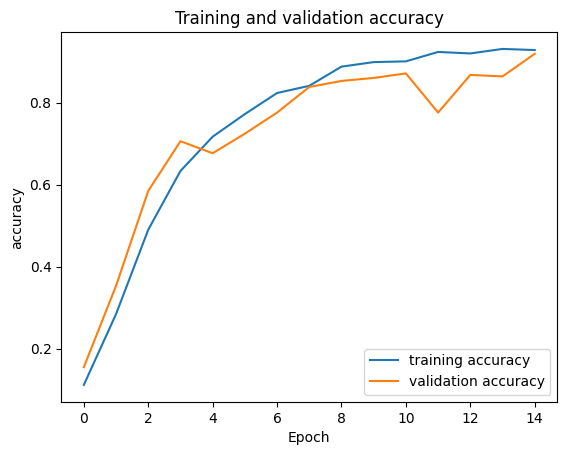

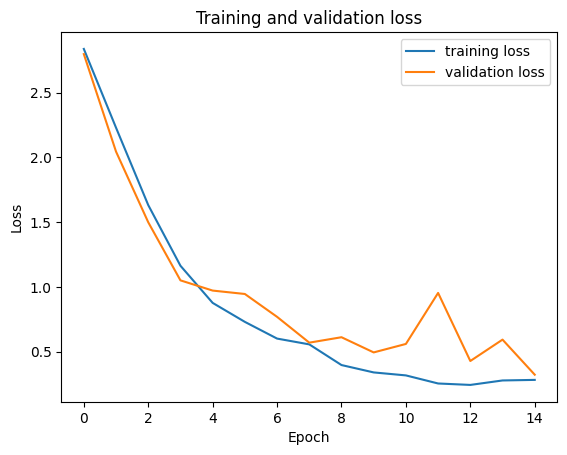

In [115]:
#Plotting the Loss and Accuracy of training vs validation data
accuracy = model2_vgg_history.history['acc']
val_accuracy = model2_vgg_history.history['val_acc']
loss = model2_vgg_history.history['loss']
val_loss = model2_vgg_history.history['val_loss']

epochs = range(len(accuracy)) # Get number of epochs

plt.plot(epochs, accuracy, label = 'training accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

**<span style='color:Blue'> Observation of CNN Model using VGGNet-16 and data augmentation techniques</span>**
- As shown in the plots, the `loss goes on decreasing and accuracy keeps incresing` over the epochs of training.
- The trends of loss and accuracy in both training and validation data are `bit converged` compared to the previous models.
- - The test accuracy on the VGGNet-16 CNN model `with data augmentation` shows `higher accuracy` compared to all the other models as shown above.
- This shows that `model is fitting` over the data appropriately.

#### Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label

In [116]:
#Summary of all the models showing train and test accuracies
model_summary = pd.DataFrame({
    "Models" : ['SVM','NN','Basic CNN', 'VGGNET16 without Augmentation', 'VGGNET16 with Augmentation'],
    "Training Accuracy": [SVM_Accuracy_train, NN_Accuracy_train[1], CNN_Accuracy_train[1], vgg_Accuracy_train[1], (model2_vgg_history.history['acc'])[-1] ],
    "Test Accuracy": [SVM_Accuracy_test, NN_Accuracy_test[1], CNN_Accuracy_test[1], vgg_Accuracy_test[1], (model2_vgg_history.history['val_acc'])[-1]  ]
}).sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
model_summary

Models  Training Accuracy  Test Accuracy
0     VGGNET16 with Augmentation           0.928309       0.919118
1  VGGNET16 without Augmentation           0.965074       0.856618
2                      Basic CNN           0.911765       0.694853
3                            SVM           0.915441       0.488971
4                             NN           0.785846       0.422794

**<span style='color:Blue'>Observations</span>**
- From the above table we can see that the model built using VGGNet-16 with data augmentation has the highest accuracy. Therefore `VGGNET16 with Augmentation` model will be used for the image prediction.

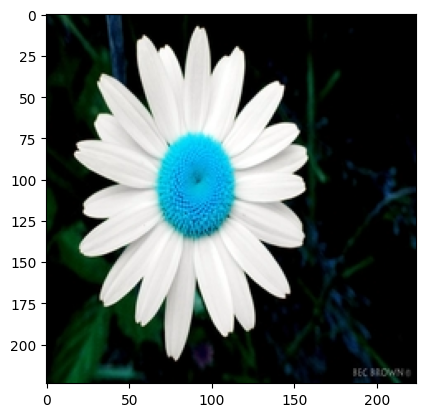

In [117]:
#Read the image
image_input = cv2.imread('Prediction.jpg')
plt.imshow(image_input)

In [118]:
#Check the shape of the image to be predicted
image_input.shape

(224, 224, 3)

In [119]:
#Check the minimum and maximum of the pixel values
np.amin(image_input), np.amax(image_input)

(0, 255)

In [120]:
#Normalise the image size before prediction
image_normalise = image_input/255

In [121]:
# Change the dimensions to make it appropriate for prediction
image_reshaped = np.expand_dims(image_normalise, axis=0)

In [122]:
image_reshaped.shape

(1, 224, 224, 3)

In [123]:
# Predict the class probabilities for image using the model2_vgg model
y_pred = model2_vgg.predict(image_reshaped)

2023-03-26 10:41:29.988424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [124]:
# Convert probability into class label
predictedClass = np.argmax(y_pred)
predictedClass

9

**<span style='color:Blue'>Observations</span>**
- From the above results, the `predicted class/label` for the input image is `9`

## **<span style='color:Blue'>Conclusions</span>**

- Overall the conventional supervised learning models such as SVM, and neural network models are not a good choice for image classification problem. These algorithms fail to conserve the spatial context features in the image data. Thus, they have poor performance in classification of images as described above.

- Convolutional neural network (CNN) algorithms on the other hand are well provisioned with techniques like filters, pooling etc. which do better job in feature/pattern extraction from images. Hence, even basic CNNs show superior performance in image classififcation over supervised learning or neural network algorithms.

- However, image classification using CNN is a very compute intensive technique as we keep adding large number of convolutional layers, filters and nodes etc. Thus is restricted by system capabilities for training purposes.

- The CNN models described above still have the scope for improvement by using the following strategies
    - Adding more number of convolutional layers, fully connected layers, number of nodes and filters etc.
    - Fine tunning parameters such as leraning rate, filter size, padding, pooling techniques, regularizations etc.
    - Using bigger pre-trained models
    - Applying k-fold cross validation techniques
    - Using ensemble techniques
    - Image augmentation with domain inputs
    
- However, experimentation with above techniques needs sufficient computational power and time.

- In the interest of time and limited system capabilities, the above model still provides a decent classification performance. 